<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/12_multi_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#다중선형회귀(multiple linear regresssion)기반 예측

필요 라이브러리 설치 (Google Colab에서 실행 시 필요)

In [1]:
!pip install yfinance numpy pandas matplotlib seaborn scikit-learn


라이브러리 불러오기

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)

In [3]:
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

/tmp/ipython-input-1137861250.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


데이터프레임 변환

In [4]:
df = df.reset_index()

특징(Feature) 생성: 날짜를 숫자로 변환

In [5]:
df["Day"] = np.arange(len(df))

추가 Feature 생성: 이동 평균(Moving Average)

In [6]:
df["MA_5"] = df["Close"].rolling(window=5).mean()  # 5일 이동 평균
df["MA_10"] = df["Close"].rolling(window=10).mean()  # 10일 이동 평균
df["MA_20"] = df["Close"].rolling(window=20).mean()  # 20일 이동 평균
df["MA_50"] = df["Close"].rolling(window=50).mean()  # 50일 이동 평균
df["MA_100"] = df["Close"].rolling(window=100).mean()  # 100일 이동 평균

결측치 처리 (이동 평균 계산으로 인한 NaN 값 제거)

In [7]:
df = df.dropna()

독립 변수(X)와 종속 변수(Y) 정의

In [8]:
features = ["Day","MA_5", "MA_10", "MA_20", "MA_50", "MA_100"]  # 다중 선형 회귀의 독립 변수들
X = df[features]
y = df["Close"]  # 종속 변수: TSLA 종가

데이터 분할 (80% 학습, 20% 테스트)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

데이터 정규화 (선택 사항)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

다중 선형 회귀 모델 학습

In [11]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

훈련 데이터

In [12]:

train_predictions = model.predict(X_train_scaled) # Assuming the model is trained in a previous cell.

예측 수행

In [13]:
y_pred = model.predict(X_test_scaled)

성능 평가

In [14]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 Mean Squared Error (MSE): {mse:.4f}")
print(f"📌 R-squared (R²): {r2:.4f}")


📌 Mean Squared Error (MSE): 46.7332
📌 R-squared (R²): 0.8634


결과 시각화

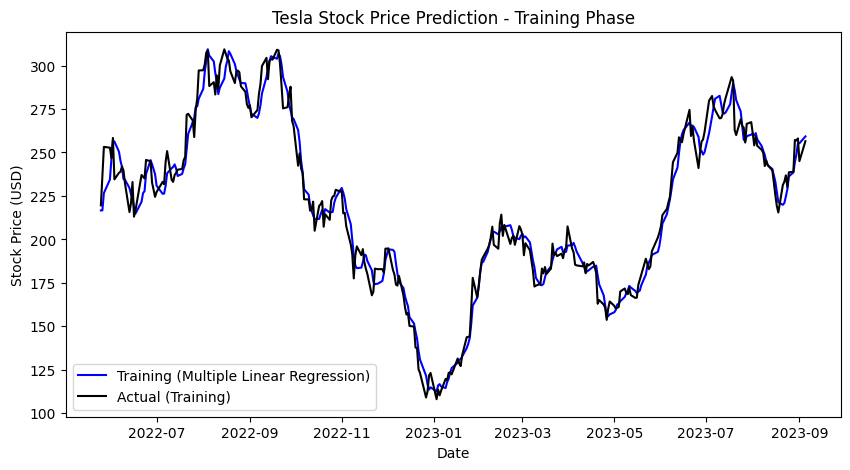

In [15]:
# 📌 7️⃣ 결과 시각화 (훈련 데이터 예측 vs 실제값)
# Define window_size and train_predictions before using them
plt.figure(figsize=(10, 5))
plt.plot(df["Date"].iloc[: len(X_train)], train_predictions, label="Training (Multiple Linear Regression)", color="blue")
plt.plot(df["Date"].iloc[: len(X_train)], y_train, label="Actual (Training)", color="black")
plt.title("Tesla Stock Price Prediction - Training Phase")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

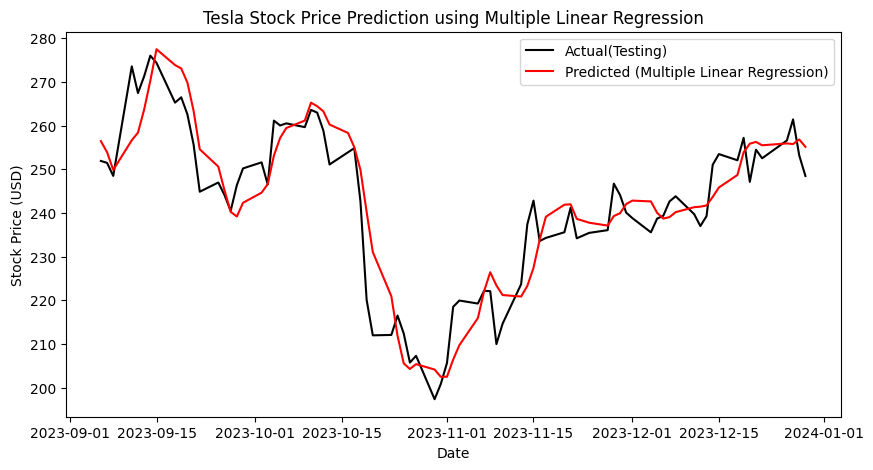

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(df["Date"].iloc[len(X_train):], y_test, label="Actual(Testing)", color="black")
plt.plot(df["Date"].iloc[len(X_train):], y_pred, label="Predicted (Multiple Linear Regression)", color="red")
plt.title("Tesla Stock Price Prediction using Multiple Linear Regression")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

[INFO] design mode = custom_X, samples=402, test_size=60, rolling_window=120


,MAE,RMSE,MAPE(%),R2
Full-Series (IS all),5.9273,7.5739,2.7119,0.9724
Full-Series (IS test),4.9995,6.6750,2.1616,0.8581
Fixed-Origin,5.1747,6.8141,2.2357,0.8521
Rolling,6.0688,7.7751,2.6546,0.8075
Expanding,5.1384,6.8235,2.2206,0.8517


,y_true,full_series(IS),fixed_origin,rolling,expanding
Date,,,,,
2023-10-05,260.049988,256.972113,257.641390,258.815942,257.641390
2023-10-06,260.529999,259.240767,259.931763,261.279508,260.048942
2023-10-09,259.670013,260.906047,261.632855,262.538922,261.771017
2023-10-10,263.619995,264.982412,265.732539,265.527339,265.778137
2023-10-11,262.989990,264.088068,264.910689,264.475873,264.864492


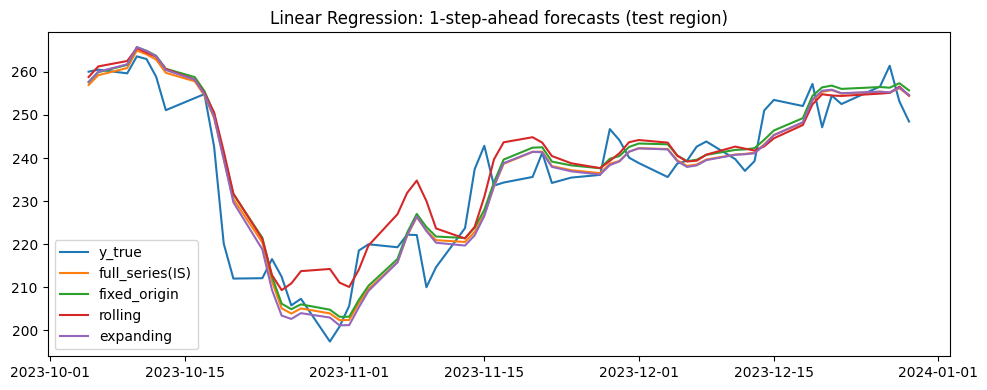

In [17]:
# ===============================================================
# Linear Regression 시계열 예측 - 4 스킴 올인원 셀
#   1) Full-series (내표본)
#   2) Fixed-origin (정적 파라미터, 1-스텝 OOS)
#   3) Rolling window (리핏, 1-스텝 OOS)
#   4) Expanding window (리핏, 1-스텝 OOS)
#
# 특징:
#  - df / X / y 자동 감지 (없으면 df에서 y/x 후보 자동 선택)
#  - x(단일 예측자)가 없으면 lag1(AR1) → 실패 시 추세(t)로 "단순선형회귀" 유지
#  - sklearn 구버전 호환(RMSE)
#  - 플롯 x축을 날짜로 표시(DATE_COL 또는 DatetimeIndex 사용)
# 출력:
#  - preds(DataFrame), metrics(DataFrame), 날짜 x축 플롯, CSV 저장
# ===============================================================
from typing import Optional, Tuple, Dict
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
import matplotlib.pyplot as plt

# --------------------------
# ★ 필요 시 여기만 수정 ★
# --------------------------
TEST_SIZE      = 60            # 테스트(평가) 구간 길이
ROLLING_WINDOW = None          # None이면 자동(min(120, 학습길이)). 예: 120
FIT_INTERCEPT  = True

# df에서 명시적으로 타깃/설명/날짜 컬럼을 지정하고 싶을 때:
Y_COL:   Optional[str] = None   # 예: "Close"  (None이면 자동 감지)
X_COL:   Optional[str] = None   # 예: "Day"    (None이면 자동 감지: Day -> lag1 -> trend)
DATE_COL:Optional[str] = "Date" # df에 날짜 컬럼명이 있다면 지정(없으면 None)

# ------------------------------------------------------------
# 도우미: 지표, 설계행렬 구성, 자동 감지
# ------------------------------------------------------------
def _safe_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """sklearn 버전에 따라 squared=False 미지원 시에도 동작하도록 RMSE 계산"""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)  # 신버전
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred))) # 구버전

def _metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    eps = 1e-12
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": _safe_rmse(y_true, y_pred),
        "MAPE(%)": float(np.mean(np.abs((y_true - y_pred) / np.where(np.abs(y_true)<eps, eps, y_true))) * 100.0),
        "R2": r2_score(y_true, y_pred),
    }

def _ensure_2d(X) -> pd.DataFrame:
    """Series/ndarray -> 2D DataFrame 보장"""
    if isinstance(X, pd.DataFrame):
        return X
    if isinstance(X, pd.Series):
        return X.to_frame(name=getattr(X, "name", "x"))
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    return pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])

def _as_series(obj, name="y") -> pd.Series:
    """ndarray도 Series로, index는 보존되면 재사용"""
    if isinstance(obj, pd.Series):
        return pd.to_numeric(obj, errors="coerce")
    if isinstance(obj, pd.DataFrame):
        # 1열만 있을 때
        if obj.shape[1] == 1:
            return pd.to_numeric(obj.iloc[:,0], errors="coerce").rename(name)
        raise ValueError("y로 DataFrame을 전달하려면 단일 컬럼이어야 합니다.")
    arr = np.asarray(obj).reshape(-1)
    return pd.Series(arr, name=name)

def _auto_pick_from_df(df: pd.DataFrame, y_col: Optional[str], x_col: Optional[str], date_col: Optional[str]):
    """df에서 y/x/날짜 자동 선택"""
    # 우선 날짜 인덱스 후보
    idx = df.index
    date_idx = None
    if date_col and date_col in df.columns:
        try:
            date_idx = pd.to_datetime(df[date_col], errors="coerce")
        except Exception:
            date_idx = None
    if isinstance(idx, pd.DatetimeIndex):
        date_idx = idx

    # y 후보
    y_candidates = [y_col] if y_col else ["y","Y","target","Target","Close","close","value","Value"]
    y_series = None
    for c in y_candidates:
        if c and c in df.columns:
            y_series = pd.to_numeric(df[c], errors="coerce")
            y_series.name = "y"
            break
    if y_series is None:
        # 숫자형 컬럼 중 첫 번째
        num_cols = [c for c in df.select_dtypes(include=[np.number]).columns]
        if num_cols:
            y_series = pd.to_numeric(df[num_cols[0]], errors="coerce").rename("y")
        else:
            raise ValueError("df에서 y로 사용할 숫자형 컬럼을 찾지 못했습니다. Y_COL을 지정하세요.")

    # x 후보(단일 특성 선호)
    x_series = None
    x_candidates = [x_col] if x_col else ["x","X","Day","day","t","T","time","Time","index","Index"]
    for c in x_candidates:
        if c and c in df.columns and c != y_series.name and pd.api.types.is_numeric_dtype(df[c]):
            x_series = pd.to_numeric(df[c], errors="coerce").rename("x")
            break

    # 날짜 인덱스 적용
    if date_idx is not None:
        y_series.index = date_idx
        if x_series is not None:
            x_series.index = date_idx

    return y_series, x_series, date_idx

def _build_design_simple_linear(y: pd.Series,
                                x: Optional[pd.Series],
                                fallback: str = "lag1_then_trend"):
    """
    단순 선형 회귀용 설계행렬:
      - x가 있으면 y ~ x
      - x가 없으면 fallback 전략:
          'lag1_then_trend'  : y ~ lag_1, 실패 시 y ~ t
    반환: (X, y, used_mode)  used_mode in {"x","lag1","trend"}
    """
    y = pd.to_numeric(pd.Series(y).dropna(), errors="coerce")
    used = None
    if x is not None:
        x = pd.to_numeric(pd.Series(x).reindex(y.index), errors="coerce")
        X = x.to_frame("x")
        valid = ~(X.isna().any(axis=1) | y.isna())
        used = "x"
        return X.loc[valid], y.loc[valid], used

    if fallback == "lag1_then_trend":
        # lag1 시도
        lag1 = y.shift(1).rename("lag1")
        X = lag1.to_frame()
        valid = ~(X.isna().any(axis=1) | y.isna())
        if valid.sum() >= 10:
            used = "lag1"
            return X.loc[valid], y.loc[valid], used
        # 추세 회귀
        t = pd.Series(np.arange(len(y), dtype=float), index=y.index, name="t")
        X = t.to_frame()
        valid = ~(X.isna().any(axis=1) | y.isna())
        used = "trend"
        return X.loc[valid], y.loc[valid], used

    # 강제 추세
    t = pd.Series(np.arange(len(y), dtype=float), index=y.index, name="t")
    X = t.to_frame()
    valid = ~(X.isna().any(axis=1) | y.isna())
    used = "trend"
    return X.loc[valid], y.loc[valid], used

# ------------------------------------------------------------
# 고정원점/롤링/확장 예측기
# ------------------------------------------------------------
def _full_series_is(X: pd.DataFrame, y: pd.Series, fit_intercept=True) -> np.ndarray:
    m = LinearRegression(fit_intercept=fit_intercept)
    m.fit(X, y)
    return m.predict(X)

def _fixed_origin(X: pd.DataFrame, y: pd.Series, test_size: int, fit_intercept=True):
    n = len(y); split = n - test_size
    X_tr, y_tr = X.iloc[:split, :], y.iloc[:split]
    X_te, y_te = X.iloc[split:, :], y.iloc[split:]
    m = LinearRegression(fit_intercept=fit_intercept)
    m.fit(X_tr, y_tr)
    yhat = m.predict(X_te)
    return y_te.index, y_te.to_numpy(), yhat

def _rolling_window(X: pd.DataFrame, y: pd.Series, test_size: int, window: int, fit_intercept=True):
    n = len(y); test_start = n - test_size
    idxs, ytrue, yhat = [], [], []
    for t in range(test_start, n):
        tr_start = max(0, t - window)
        X_tr, y_tr = X.iloc[tr_start:t, :], y.iloc[tr_start:t]
        X_te = X.iloc[t:t+1, :]
        m = LinearRegression(fit_intercept=fit_intercept)
        m.fit(X_tr, y_tr)
        yhat.append(m.predict(X_te)[0])
        ytrue.append(y.iloc[t])
        idxs.append(y.index[t])
    return pd.Index(idxs), np.array(ytrue), np.array(yhat)

def _expanding_window(X: pd.DataFrame, y: pd.Series, test_size: int, fit_intercept=True):
    n = len(y); test_start = n - test_size
    idxs, ytrue, yhat = [], [], []
    for t in range(test_start, n):
        X_tr, y_tr = X.iloc[:t, :], y.iloc[:t]
        X_te = X.iloc[t:t+1, :]
        m = LinearRegression(fit_intercept=fit_intercept)
        m.fit(X_tr, y_tr)
        yhat.append(m.predict(X_te)[0])
        ytrue.append(y.iloc[t])
        idxs.append(y.index[t])
    return pd.Index(idxs), np.array(ytrue), np.array(yhat)

# ------------------------------------------------------------
# 0) 데이터 자동 감지 (df, X, y → 우선 사용)
# ------------------------------------------------------------
y_series: Optional[pd.Series] = None
x_series: Optional[pd.Series] = None
X_design: Optional[pd.DataFrame] = None
date_index: Optional[pd.DatetimeIndex] = None

_glob = globals()

# 0-1) 우선순위: 이미 만든 y/X가 있으면 그대로 사용
if "y" in _glob:
    try:
        y_series = _as_series(_glob["y"], name="y")
    except Exception:
        y_series = None

if "X" in _glob and y_series is not None:
    try:
        X_design = _ensure_2d(_glob["X"]).reindex(y_series.index)
    except Exception:
        X_design = None

# 0-2) df 기반 자동 탐지 (y, x, 날짜)
if y_series is None or X_design is None:
    if "df" in _glob:
        _df = _glob["df"].copy()
        y2, x2, dt_idx = _auto_pick_from_df(_df, Y_COL, X_COL, DATE_COL)
        if y_series is None:
            y_series = y2
        if X_design is None and x2 is not None:
            x_series = x2
        if date_index is None:
            date_index = dt_idx

# 0-3) 날짜 인덱스 보강 (df.Date가 있는데 위에서 못 썼다면)
if date_index is None and "df" in _glob and DATE_COL and DATE_COL in _glob["df"].columns:
    try:
        date_index = pd.to_datetime(_glob["df"][DATE_COL], errors="coerce")
    except Exception:
        date_index = None

if date_index is not None:
    if y_series is not None:
        y_series.index = date_index[:len(y_series)]
    if x_series is not None:
        x_series.index = date_index[:len(x_series)]
    if X_design is not None:
        X_design.index = date_index[:len(X_design)]

# 0-4) 여전히 y가 없으면 에러
if y_series is None:
    raise RuntimeError("타깃 y를 찾지 못했습니다. df/Y_COL 또는 y 변수를 준비해 주세요.")

# ------------------------------------------------------------
# 1) 단순 선형회귀 설계행렬 구성 (x가 없으면 lag1 또는 trend 사용)
# ------------------------------------------------------------
if X_design is None:
    X_design, y_clean, used_mode = _build_design_simple_linear(y_series, x_series, fallback="lag1_then_trend")
else:
    # 다중특성 X(이미 생성됨) - 여전히 '선형회귀'
    X_design = X_design.astype(float)
    y_clean  = y_series.astype(float).reindex(X_design.index)
    valid = ~(X_design.isna().any(axis=1) | y_clean.isna())
    X_design, y_clean = X_design.loc[valid], y_clean.loc[valid]
    used_mode = "custom_X"

n = len(y_clean)
assert 1 <= TEST_SIZE < n, f"TEST_SIZE(={TEST_SIZE})는 1~{n-1} 사이여야 합니다."
test_start = n - TEST_SIZE
test_index = y_clean.index[test_start:]

# ------------------------------------------------------------
# 2) 4 스킴 실행
# ------------------------------------------------------------
# Full-series (IS 전체/IS 테스트절단)
yhat_is_all  = _full_series_is(X_design, y_clean, fit_intercept=FIT_INTERCEPT)
yhat_is_test = yhat_is_all[test_start:]

# Fixed-origin
idx_fo, y_true_fo, yhat_fo = _fixed_origin(X_design, y_clean, test_size=TEST_SIZE, fit_intercept=FIT_INTERCEPT)

# Rolling
if ROLLING_WINDOW is None:
    ROLLING_WINDOW = min(120, n - TEST_SIZE)
idx_rw, y_true_rw, yhat_rw = _rolling_window(X_design, y_clean, test_size=TEST_SIZE, window=ROLLING_WINDOW, fit_intercept=FIT_INTERCEPT)

# Expanding
idx_ex, y_true_ex, yhat_ex = _expanding_window(X_design, y_clean, test_size=TEST_SIZE, fit_intercept=FIT_INTERCEPT)

# ------------------------------------------------------------
# 3) 결과 취합 & 지표
# ------------------------------------------------------------
preds = pd.DataFrame(index=test_index)
preds["y_true"]            = y_clean.iloc[test_start:].to_numpy()
preds["full_series(IS)"]   = yhat_is_test
preds["fixed_origin"]      = pd.Series(yhat_fo, index=idx_fo)
preds["rolling"]           = pd.Series(yhat_rw, index=idx_rw)
preds["expanding"]         = pd.Series(yhat_ex, index=idx_ex)

metrics = pd.DataFrame({
    "Full-Series (IS all)" : _metrics(y_clean.to_numpy(), yhat_is_all),
    "Full-Series (IS test)": _metrics(preds["y_true"].to_numpy(), preds["full_series(IS)"].to_numpy()),
    "Fixed-Origin"         : _metrics(preds["y_true"].to_numpy(), preds["fixed_origin"].to_numpy()),
    "Rolling"              : _metrics(preds["y_true"].to_numpy(), preds["rolling"].to_numpy()),
    "Expanding"            : _metrics(preds["y_true"].to_numpy(), preds["expanding"].to_numpy()),
}).T

# ------------------------------------------------------------
# 4) 표시 및(선택) 저장
# ------------------------------------------------------------
print(f"[INFO] design mode = {used_mode}, samples={n}, test_size={TEST_SIZE}, rolling_window={ROLLING_WINDOW}")
display(metrics.round(4))
display(preds.head())

# ----- x축 날짜 보장 플롯 -----
x_idx = preds.index
try:
    x_idx = pd.to_datetime(x_idx)
except Exception:
    if "df" in globals() and DATE_COL and DATE_COL in df.columns:
        x_idx = pd.to_datetime(df[DATE_COL].iloc[-len(preds):].values, errors="coerce")

plt.figure(figsize=(10,4))
plt.plot(x_idx, preds["y_true"], label="y_true")
plt.plot(x_idx, preds["full_series(IS)"], label="full_series(IS)")
plt.plot(x_idx, preds["fixed_origin"], label="fixed_origin")
plt.plot(x_idx, preds["rolling"], label="rolling")
plt.plot(x_idx, preds["expanding"], label="expanding")
plt.title("Linear Regression: 1-step-ahead forecasts (test region)")
plt.legend()
plt.tight_layout()
plt.show()

# 파일로 저장(원하면 경로 바꾸세요)
#preds.to_csv("forecast_preds_linear.csv", index=True)
#metrics.to_csv("forecast_metrics_linear.csv", index=True)
#print("[INFO] saved: forecast_preds_linear.csv, forecast_metrics_linear.csv")
